# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
#env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [ 0.02803708 -0.22961454 -0.02932536  0.24674302] 0 1.0 False {}
state, action, reward, done, info: [ 0.02344479 -0.0340863  -0.0243905  -0.05504365] 1 1.0 False {}
state, action, reward, done, info: [ 0.02276307  0.16137673 -0.02549138 -0.35532109] 1 1.0 False {}
state, action, reward, done, info: [ 0.0259906  -0.03337368 -0.0325978  -0.07078404] 0 1.0 False {}
state, action, reward, done, info: [ 0.02532313  0.16220008 -0.03401348 -0.37357088] 1 1.0 False {}
state, action, reward, done, info: [ 0.02856713  0.35778828 -0.0414849  -0.67678152] 1 1.0 False {}
state, action, reward, done, info: [ 0.03572289  0.55346134 -0.05502053 -0.98223165] 1 1.0 False {}
state, action, reward, done, info: [ 0.04679212  0.74927568 -0.07466516 -1.29167656] 1 1.0 False {}
state, action, reward, done, info: [ 0.06177763  0.94526325 -0.10049869 -1.60677   ] 1 1.0 False {}
state, action, reward, done, info: [ 0.0806829   1.14141963 -0.13263409 -1.92901684] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [14]:
def model_input(state_size, lstm_size, batch_size=1):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    #labelQs = tf.placeholder(tf.float32, [None], name='labelQs')
        
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return actions, states, targetQs, cell, initial_state

In [15]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [16]:
# def model_outputs(action_size, hidden_size, states, cell, initial_state):
#     actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
#                                             lstm_size=hidden_size, num_classes=action_size)
#     return actions_logits, final_state

In [17]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
#     loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
#                                                                   labels=tf.nn.sigmoid(targetQs[1:])))
    return actions_logits, final_state, loss

In [18]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
#         # Output of the Model: calculating the loss and forwad pass
#         self.actions_logits, self.final_state = model_outputs(
#             action_size=action_size, hidden_size=hidden_size, 
#             states=self.states, cell=cell, initial_state=self.initial_state)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [20]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

In [21]:
# episode_total_reward = deque(maxlen=10)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [23]:
# Training parameters
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [26]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [27]:
memory.buffer[0]

[array([0.03167448, 0.01401935, 0.02102474, 0.04001393]),
 0,
 array([ 0.03195487, -0.18139769,  0.02182502,  0.33925552]),
 1.0,
 0.0]

In [28]:
# states, rewards, actions

In [ ]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    total_step = 0 # Explore or exploit parameter
    episode_loss = deque(maxlen=batch_size)
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
            actions_logits = sess.run(model.actions_logits, 
                                      feed_dict = {model.states: next_states, 
                                                   model.initial_state: final_states[0].reshape([1, -1])})
            nextQs = np.max(actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _ = sess.run([model.loss, model.opt], 
                               feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.targetQs: targetQs,
                                            model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)),
              'ExploreP: {:.4f}'.format(explore_p))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model3.ckpt')

Episode: 0 meanReward: 19.0000 meanLoss: 1.8555 ExploreP: 0.9981
Episode: 1 meanReward: 14.5000 meanLoss: 7.7982 ExploreP: 0.9971
Episode: 2 meanReward: 13.0000 meanLoss: 11.7375 ExploreP: 0.9961
Episode: 3 meanReward: 18.7500 meanLoss: 7.2698 ExploreP: 0.9926
Episode: 4 meanReward: 19.4000 meanLoss: 5.4157 ExploreP: 0.9904
Episode: 5 meanReward: 18.5000 meanLoss: 9.0220 ExploreP: 0.9891
Episode: 6 meanReward: 18.2857 meanLoss: 11.4750 ExploreP: 0.9874
Episode: 7 meanReward: 19.2500 meanLoss: 9.4785 ExploreP: 0.9849
Episode: 8 meanReward: 18.5556 meanLoss: 9.8010 ExploreP: 0.9836
Episode: 9 meanReward: 18.9000 meanLoss: 12.5939 ExploreP: 0.9815
Episode: 10 meanReward: 20.2727 meanLoss: 9.7284 ExploreP: 0.9782
Episode: 11 meanReward: 19.5833 meanLoss: 9.8080 ExploreP: 0.9770
Episode: 12 meanReward: 20.3846 meanLoss: 7.2012 ExploreP: 0.9741
Episode: 13 meanReward: 21.0000 meanLoss: 11.8704 ExploreP: 0.9713
Episode: 14 meanReward: 21.2667 meanLoss: 13.9603 ExploreP: 0.9689
Episode: 15 mea

Episode: 123 meanReward: 36.2188 meanLoss: 44.1763 ExploreP: 0.6940
Episode: 124 meanReward: 36.6562 meanLoss: 30.0719 ExploreP: 0.6916
Episode: 125 meanReward: 37.3750 meanLoss: 29.7347 ExploreP: 0.6887
Episode: 126 meanReward: 37.5938 meanLoss: 8.4834 ExploreP: 0.6863
Episode: 127 meanReward: 37.7812 meanLoss: 20.2507 ExploreP: 0.6847
Episode: 128 meanReward: 37.4375 meanLoss: 32.5105 ExploreP: 0.6835
Episode: 129 meanReward: 38.3125 meanLoss: 18.2685 ExploreP: 0.6801
Episode: 130 meanReward: 37.8750 meanLoss: 22.4417 ExploreP: 0.6793
Episode: 131 meanReward: 35.0938 meanLoss: 42.0542 ExploreP: 0.6781
Episode: 132 meanReward: 36.5312 meanLoss: 16.3450 ExploreP: 0.6730
Episode: 133 meanReward: 33.9375 meanLoss: 20.9813 ExploreP: 0.6720
Episode: 134 meanReward: 33.0000 meanLoss: 19.8883 ExploreP: 0.6713
Episode: 135 meanReward: 38.3125 meanLoss: 7.9742 ExploreP: 0.6587
Episode: 136 meanReward: 37.6562 meanLoss: 87.7673 ExploreP: 0.6578
Episode: 137 meanReward: 37.0625 meanLoss: 77.3160

Episode: 243 meanReward: 56.4375 meanLoss: 1528.9994 ExploreP: 0.3885
Episode: 244 meanReward: 55.8438 meanLoss: 1521.2595 ExploreP: 0.3881
Episode: 245 meanReward: 50.5000 meanLoss: 1475.2307 ExploreP: 0.3877
Episode: 246 meanReward: 46.8125 meanLoss: 1482.5260 ExploreP: 0.3872
Episode: 247 meanReward: 46.2812 meanLoss: 1465.4651 ExploreP: 0.3868
Episode: 248 meanReward: 41.5625 meanLoss: 1482.1561 ExploreP: 0.3864
Episode: 249 meanReward: 41.0938 meanLoss: 1405.7157 ExploreP: 0.3859
Episode: 250 meanReward: 40.6875 meanLoss: 1368.0604 ExploreP: 0.3855
Episode: 251 meanReward: 34.8750 meanLoss: 1355.4873 ExploreP: 0.3852
Episode: 252 meanReward: 33.8125 meanLoss: 1407.3969 ExploreP: 0.3848
Episode: 253 meanReward: 28.5625 meanLoss: 1408.3229 ExploreP: 0.3843
Episode: 254 meanReward: 24.6562 meanLoss: 1398.8888 ExploreP: 0.3839
Episode: 255 meanReward: 23.7500 meanLoss: 1356.2793 ExploreP: 0.3832
Episode: 256 meanReward: 23.3438 meanLoss: 1307.8210 ExploreP: 0.3828
Episode: 257 meanRew

Episode: 362 meanReward: 208.8750 meanLoss: 1.4039 ExploreP: 0.1126
Episode: 363 meanReward: 212.5312 meanLoss: 17.3541 ExploreP: 0.1076
Episode: 364 meanReward: 208.4688 meanLoss: 276.4479 ExploreP: 0.1075
Episode: 365 meanReward: 204.0312 meanLoss: 444.3580 ExploreP: 0.1073
Episode: 366 meanReward: 209.9375 meanLoss: 17.6224 ExploreP: 0.1046
Episode: 367 meanReward: 218.6562 meanLoss: 13.1574 ExploreP: 0.1000
Episode: 368 meanReward: 203.6250 meanLoss: 247.1835 ExploreP: 0.0998
Episode: 369 meanReward: 206.2188 meanLoss: 10.8975 ExploreP: 0.0962
Episode: 370 meanReward: 204.6875 meanLoss: 32.8970 ExploreP: 0.0946
Episode: 371 meanReward: 214.6250 meanLoss: 3.2934 ExploreP: 0.0905
Episode: 372 meanReward: 215.5312 meanLoss: 45.7641 ExploreP: 0.0890
Episode: 373 meanReward: 214.5312 meanLoss: 46.8563 ExploreP: 0.0878
Episode: 374 meanReward: 215.5312 meanLoss: 50.6885 ExploreP: 0.0862
Episode: 375 meanReward: 207.0625 meanLoss: 154.1705 ExploreP: 0.0845
Episode: 376 meanReward: 216.125

Episode: 481 meanReward: 226.7500 meanLoss: 25.0663 ExploreP: 0.0140
Episode: 482 meanReward: 213.2812 meanLoss: 42.5829 ExploreP: 0.0139
Episode: 483 meanReward: 200.4688 meanLoss: 11.6991 ExploreP: 0.0139
Episode: 484 meanReward: 189.5938 meanLoss: 5.0247 ExploreP: 0.0138
Episode: 485 meanReward: 189.5938 meanLoss: 1.3832 ExploreP: 0.0136
Episode: 486 meanReward: 179.3438 meanLoss: 29.6784 ExploreP: 0.0136
Episode: 487 meanReward: 192.7500 meanLoss: 1.1867 ExploreP: 0.0134
Episode: 488 meanReward: 207.3750 meanLoss: 2.1987 ExploreP: 0.0132
Episode: 489 meanReward: 207.3750 meanLoss: 15.2709 ExploreP: 0.0131
Episode: 490 meanReward: 211.4375 meanLoss: 14.4314 ExploreP: 0.0130
Episode: 491 meanReward: 215.0938 meanLoss: 43.2845 ExploreP: 0.0130
Episode: 492 meanReward: 220.2188 meanLoss: 20.5609 ExploreP: 0.0130
Episode: 493 meanReward: 223.7500 meanLoss: 12.6692 ExploreP: 0.0129
Episode: 494 meanReward: 238.2500 meanLoss: 3.6229 ExploreP: 0.0128
Episode: 495 meanReward: 225.5312 meanL

Episode: 599 meanReward: 14.3438 meanLoss: 1498.0432 ExploreP: 0.0115
Episode: 600 meanReward: 14.2812 meanLoss: 1467.5280 ExploreP: 0.0115
Episode: 601 meanReward: 14.1875 meanLoss: 1463.2268 ExploreP: 0.0115
Episode: 602 meanReward: 14.1875 meanLoss: 1510.8684 ExploreP: 0.0115
Episode: 603 meanReward: 14.1250 meanLoss: 1567.5067 ExploreP: 0.0115
Episode: 604 meanReward: 14.1562 meanLoss: 1570.2809 ExploreP: 0.0115
Episode: 605 meanReward: 14.0938 meanLoss: 1518.1061 ExploreP: 0.0115
Episode: 606 meanReward: 14.0938 meanLoss: 1526.1163 ExploreP: 0.0115
Episode: 607 meanReward: 14.1250 meanLoss: 1531.3870 ExploreP: 0.0115
Episode: 608 meanReward: 14.0625 meanLoss: 1528.2032 ExploreP: 0.0115
Episode: 609 meanReward: 13.8750 meanLoss: 1561.2769 ExploreP: 0.0115
Episode: 610 meanReward: 13.7812 meanLoss: 1590.7172 ExploreP: 0.0115
Episode: 611 meanReward: 13.7812 meanLoss: 1553.5946 ExploreP: 0.0115
Episode: 612 meanReward: 13.7500 meanLoss: 1570.7556 ExploreP: 0.0115
Episode: 613 meanRew

Episode: 717 meanReward: 10.5938 meanLoss: 1222.9071 ExploreP: 0.0108
Episode: 718 meanReward: 10.5938 meanLoss: 1315.0004 ExploreP: 0.0108
Episode: 719 meanReward: 10.6250 meanLoss: 1295.7953 ExploreP: 0.0108
Episode: 720 meanReward: 10.6250 meanLoss: 1252.3107 ExploreP: 0.0108
Episode: 721 meanReward: 10.5938 meanLoss: 1228.5435 ExploreP: 0.0108
Episode: 722 meanReward: 10.5938 meanLoss: 1172.8031 ExploreP: 0.0108
Episode: 723 meanReward: 10.6562 meanLoss: 1262.5013 ExploreP: 0.0108
Episode: 724 meanReward: 10.6562 meanLoss: 1070.5933 ExploreP: 0.0108
Episode: 725 meanReward: 10.6562 meanLoss: 1073.2683 ExploreP: 0.0108
Episode: 726 meanReward: 10.5938 meanLoss: 967.4330 ExploreP: 0.0108
Episode: 727 meanReward: 10.5312 meanLoss: 1123.0015 ExploreP: 0.0108
Episode: 728 meanReward: 10.5000 meanLoss: 1002.4890 ExploreP: 0.0108
Episode: 729 meanReward: 10.4375 meanLoss: 1072.6544 ExploreP: 0.0108
Episode: 730 meanReward: 10.3750 meanLoss: 1013.4668 ExploreP: 0.0108
Episode: 731 meanRewa

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

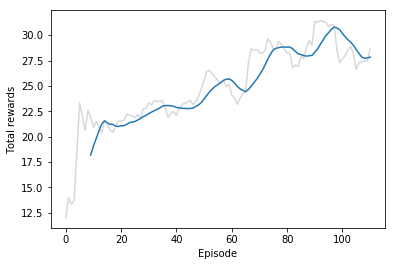

In [182]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

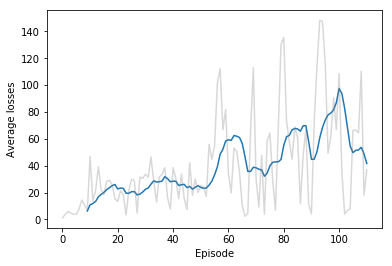

In [183]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.